# Network Analysis

In the context of analyzing the impact of an actor's popularity on movie ratings, network analysis allows us to look at the connections between actors and how they may influence each other's contribution to the ratings. By visualizing the relationships between actors as a network, we can identify patterns and communities within the movie industry, and gain a more nuanced understanding of the ways in which actors' popularity contribute to ratings. 

Overall, incorporating network analysis into our analysis of actor contributions to movie ratings can provide valuable insights and help us better understand the complex relationships within the data.

Steps:
- network with weights = number of movies done together 
- communities (highlight within & between on graph)
- movie rating differences per community? CORRELATION -> t-test 
- CAUSATION:
    - split into 2 categories: movies with acotrs from same community vs. across communities 
    - paired-matching -> movies based on genre, (languages, countries, release year, runtime)
    - propoensity score 
    - movie rating differences across/within communities? 

Repeat with weights = ethnicity (the closer the greater the weight)? reverse age difference (the smaller the greater the weight)? number of awards together? 

Q: how to measure distance among ethnicities? is it even possible? 

In [2]:
# Import all libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import networkx as nx

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Open the cleaned datasets from the cleaned_datasets folder
movies = pd.read_csv('cleaned_datasets/movies_clean.csv', sep=',') #TODO sep ?
characters = pd.read_csv('cleaned_datasets/characters_clean.csv')
actors_info = pd.read_csv('cleaned_datasets/actors_info_clean.csv')
actors_list = pd.read_csv('cleaned_datasets/actors_list_clean.csv')

In [4]:
# load data
#movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)

# budget = pd.read_csv(
#     BUDGET_PATH, usecols=["id", "budget", "original_title", "release_date", "runtime"]
# )

# adding column for release year in movies and budget dataframes.
# IMDb dataset already contains release year.
# movies["year_released"] = pd.to_datetime(   
#     movies["year_release"], infer_datetime_format=True, errors="coerce"
# ).dt.year   #TODO check type of year_release in movies dataset 

# removing rows with null values in year_released
#movies = movies[~movies["year_release"].isna()] #TODO for later 

# removing rows with duplicate of ('movie_name', 'release_year', 'movie_runtime') in movies
#movies = movies.drop_duplicates(subset=["movie_name", "year_released", "movie_runtime"])
#TODO


# # column that idicate if date were given or only year
# movies["date_given"] = movies["release_date"].apply(lambda x: is_given_date(str(x)))

# # transform the string representation to date-time representation
# movies["release_date"] = pd.to_datetime(
#     movies["release_date"], errors="coerce", utc=True
# )

# # extract year and month (if no month are given the default is set to January)
# movies["release_year"] = pd.DatetimeIndex(movies["release_date"]).year
# movies["release_month"] = pd.DatetimeIndex(movies["release_date"]).month

# # filter out movies without release date
# movies = movies[movies["release_date"].notna()]

In [5]:
movies.isna().sum()
#TODO movies is object

wikipedia_id                   0
freebase_id                    0
name                           0
release_date                   0
revenue                    21460
runtime                        0
languages                      0
countries                      0
genres                         0
year_release                   0
averageRating                  0
numVotes                       0
average_award_cumcount      3702
average_movies_cumcount     3702
award_cumcount              3702
movies_cumcount             3702
dtype: int64

In [6]:
actors_list.isna().sum()

name        1
awards      0
movies      1
Fame        0
Liked       0
Disliked    0
Neutral     0
dtype: int64

Note (!)  null values for 1 in name, movies and below 1 in id, name, movies

In [7]:
actors_info.isna().sum()
#TODO movies is float64

actor_birth           76097
actor_gender          37800
actor_height         121294
actor_etnicity       125974
actor_name                1
freebase_actor_id         1
awards                    0
movies                    1
Fame                      0
Liked                     0
Disliked                  0
Neutral                   0
dtype: int64

In [8]:
characters.isna().sum()

wikipedia_movie_id                 0
freebase_movie_id                  0
movie_release_date                 0
character_name                 90614
actor_birth                    37774
actor_gender                   16299
actor_height                  107893
actor_etnicity                134592
actor_name                       149
actor_age_at_release           56626
freebase_char_actor_map_id         0
freebase_character_id          90610
freebase_actor_id                  0
Fame                               0
Liked                              0
Disliked                           0
Neutral                            0
award_cumcount                     0
movies_cumcount                    0
dtype: int64

The character dataset does not contain any missing freebase_actor_id or freebase_movie_id, therefore no entries have to be removed. 

In [9]:
# Removing actors without movie information
actors_list = actors_list[actors_list['movies'].notna()]
actors_info = actors_info[actors_info['movies'].notna()]

In [10]:
actors_list.isna().sum()

name        0
awards      0
movies      0
Fame        0
Liked       0
Disliked    0
Neutral     0
dtype: int64

In [11]:
actors_info.isna().sum() 

actor_birth           76096
actor_gender          37799
actor_height         121293
actor_etnicity       125973
actor_name                0
freebase_actor_id         0
awards                    0
movies                    0
Fame                      0
Liked                     0
Disliked                  0
Neutral                   0
dtype: int64

One actor had missing name, id and movie information. The actor was removed from the working dataframes.

In [12]:
# Removing movies from before 2000
movies = movies[movies['year_release'] >= 2000] #TODO

# Merging movies with characters on freebase_movie_id.
movies_characters = pd.merge(
    left=movies,
    right=characters,
    left_on="freebase_id",  # Column from the "movies" DataFrame
    right_on="freebase_movie_id"  # Column from the "characters" DataFrame
)

# Rename the merged column to a specific name
movies_characters = movies_characters.rename(columns={"freebase_id": "freebase_movie_id"})

# We filter out duplicated combinations of 'freebase_movie_id' and 'freebase_actor_ID'.
movies_characters = movies_characters.drop_duplicates(
    subset=["freebase_movie_id", "freebase_actor_id"], keep="first"
)
movies_characters.shape

(61752, 35)

## One Hot Encoding of Actors

In [13]:
# One Hot Encoding of Actors
actor_one_hot = pd.get_dummies(
    data=movies_characters, columns=["freebase_actor_id"]
)

# # One Hot Encoding of Movies
# movie_one_hot = pd.get_dummies(
#     data=movies_characters, columns=["freebase_movie_id"]
# )

# Only include freebase_movie_id and one hot encoding of actors in dataframe
actor_one_hot1 = actor_one_hot.filter(
    regex="wikipedia_id|freebase_actor_id_" #TODO with freebase id
)

actor_one_hot1.shape

(61752, 35973)

In [14]:
# Get the data types of the values inside actor_one_hot
data_types = actor_one_hot1.dtypes

# Display the data types
print(data_types)

wikipedia_id                   int64
freebase_actor_id_/m/010p3     uint8
freebase_actor_id_/m/010xjr    uint8
freebase_actor_id_/m/011_3s    uint8
freebase_actor_id_/m/011_8     uint8
                               ...  
freebase_actor_id_/m/0ywqc     uint8
freebase_actor_id_/m/0yxl      uint8
freebase_actor_id_/m/0z05l     uint8
freebase_actor_id_/m/0z4s      uint8
freebase_actor_id_/m/0zcbl     uint8
Length: 35973, dtype: object


Number of actors that have played in more than 5 movies: 1581
Number of actors that have played in more than 10 movies: 330


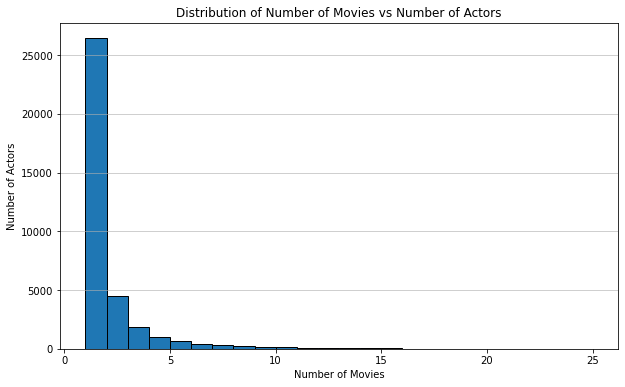

In [15]:
# We want to try different thresholds for how many actors we include.
# Exploring actors that have played in more than 10 and 15 movies.
actor_one_hot_5 = actor_one_hot1.loc[:, actor_one_hot1.sum(axis=0) > 5]
actor_one_hot_10 = actor_one_hot1.loc[:, actor_one_hot1.sum(axis=0) > 10]
print(
    "Number of actors that have played in more than 5 movies: {}".format(
        actor_one_hot_5.shape[1] - 1
    )
)
print(
    "Number of actors that have played in more than 10 movies: {}".format(
        actor_one_hot_10.shape[1] - 1
    )
)

# Calculate the number of actors that have played in each number of movies
num_actors_per_movie_count = actor_one_hot1.sum(axis=0)

# Remove the count of the "freebase_movie_id" column
num_actors_per_movie_count = num_actors_per_movie_count.drop("wikipedia_id")

# Create a histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(num_actors_per_movie_count, bins=range(1, num_actors_per_movie_count.max() + 1), edgecolor='k')
plt.xlabel('Number of Movies')
plt.ylabel('Number of Actors')
plt.title('Distribution of Number of Movies vs Number of Actors')
plt.grid(axis='y', alpha=0.75)
plt.show()

We decided to restrict our dataframe to actors who worked in more than 5 movies. 

In [16]:
# Grouping movies such that every movie correspond to only one row in the dataframe
actor_one_hot_5 = actor_one_hot_5.groupby("wikipedia_id").agg("sum")

# Merging dummy actor columns with the movies
movies_acotrs_5 = pd.merge(
    movies, actor_one_hot_5, left_on="wikipedia_id", right_index=True
)

movies_acotrs_5.shape

(6434, 1597)

Missing all the genre, languages, countries, etc. 1-hot preprocessing

In [17]:
# create a graph
G = nx.Graph()

# Creat a graph 

# intialize dictionaries to store the total revenue and number of movies for each actor
actor_ratings = {}  # dictionary to store total box office revenue and number of movies for each actor
actor_movies = {}  # dictionary to store the movies that each actor has appeared in

# iterate over the rows in the movies_binary_actors10
for _, row in movies_acotrs_5.iterrows():
    # get the movie's box office revenue
    rating = row['averageRating']

    # get the actors in this movie
    actors = [actor for actor in row.index if actor.startswith('freebase_actor_ID') and row[actor] == 1]
    for actor in actors:
        if actor not in actor_ratings:
            actor_ratings[actor] = [rating, 1]  # store total revenue and number of movies for each actor
            G.add_node(actor, size=rating)  # add actor as a node to the graph, with size equal to revenue
            actor_movies[actor] = [row['wikipedia_movie_ID']]  # store the movies that this actor has appeared in
        else:
            actor_ratings[actor][0] += rating  # update total revenue for this actor
            actor_ratings[actor][1] += 1  # update number of movies for this actor
            G.nodes[actor]['size'] = actor_ratings[actor][0] / actor_ratings[actor][1]  # update size of node
            actor_movies[actor].append(row['wikipedia_movie_ID'])  # add this movie to the list of movies for this actor
    
    # add edges between actors that have played in the same movie
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            actor1 = actors[i]
            actor2 = actors[j]
            if G.has_edge(actor1, actor2):
                G[actor1][actor2]['weight'] += 1  # update the weight of the existing edge
            else:
                G.add_edge(actor1, actor2, weight=1)  # add a new edge with weight 1

# update the weight of each edge to be the number of movies that the actors have played in together
for actor1, actor2 in G.edges():
    movies1 = actor_movies[actor1]
    movies2 = actor_movies[actor2]
    weight = len(set(movies1).intersection(movies2))  # number of movies that both actors have appeared in
    G[actor1][actor2]['weight'] = weight

In [18]:
import matplotlib.patches as mpatches

from PIL import Image, ImageDraw
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def get_ab_from_actor(node, node_sizes, pos):
    # read the image file for this node
    img = Image.open('./img/' + node.split('/m/')[0] + node.split('_ID_')[1].replace('/', ':') + '.jpg')

    h,w = img.size
    # Resize the image to a square shape
    side_length = min(h, w)
    # crop the image to a square
    img = img.crop(((h-side_length)//2, (w-side_length)//2, (h+side_length)//2, (w+side_length)//2))
    img = img.resize((800,800))
    h,w = img.size
    
    # creating luminous image
    lum_img = Image.new('L',[h,w] ,0) 
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(0,0),(h,w)],0,360,fill=255)
    img_arr = np.array(img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr, lum_img_arr))

    image = Image.fromarray(final_img_arr)
    
    # create an OffsetImage object for the image
    image_offset = OffsetImage(image, zoom=node_sizes[node]/2000000000) #, cmap=plt.cm.gray_r)
    
    # create an AnnotationBbox object for the image
    ab = AnnotationBbox(image_offset, pos[node], frameon=False)
    
    return ab


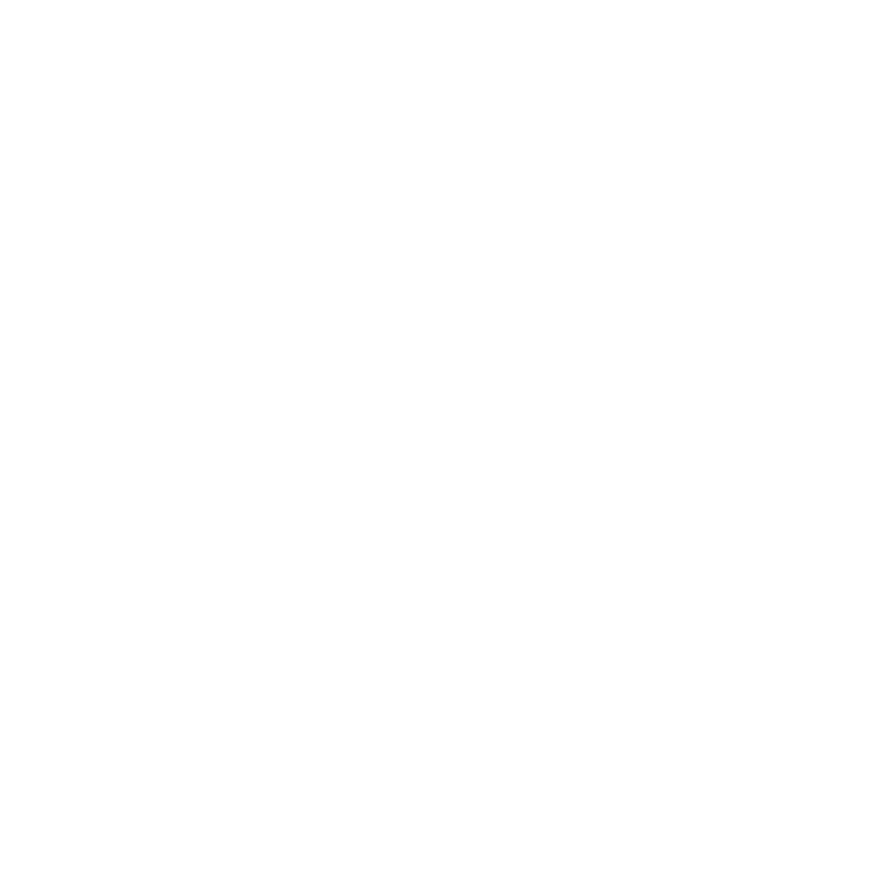

In [19]:
# plot the graph with images of the actors as nodes
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# create a dictionary that maps actor IDs to actor names
actor_names = characters.set_index('freebase_actor_id')['actor_name'].to_dict()

# create a new dictionary that maps the actor IDs in the movies_binary_actors10 dataframe to the actor names
labels = {'freebase_actor_ID_'+actor: actor_names[actor] for actor in actor_names}

# create a figure
plt.figure(figsize=(12,12))

# get the node sizes
node_sizes = nx.get_node_attributes(G, 'size')

# get the edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')  

# position the nodes randomly
pos = nx.random_layout(G, seed=3)

for node in G.nodes():
    plt.gca().add_artist(get_ab_from_actor(node, node_sizes, pos))

# draw the graph
nx.draw(G, pos=pos, with_labels=False, node_size=[node_sizes[v]/500000 for v in G.nodes()], edge_color='lightgreen', width=[w**2 for _, _, w in G.edges(data='weight')], node_color='lightblue')

# save the plot
# plt.savefig('actor_network.png', dpi=300, bbox_inches='tight')

# show the plot
plt.show()

In [20]:
import community

# Use the Louvain method to detect communities in the graph
partition = community.best_partition(G, random_state=1, weight='weight')

communities = {}

# Print the actors in each community
for actor, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [actor]
    else:
        communities[community_id].append(actor)
   